In [24]:
#import library
import numpy as np
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import tecplot_io as tec
import h5py
import os

In [25]:
#function get power_density_average
#require working directory and return power density average
#input: path
#output: power density average
def power_density_average(path):
  #Declare working directory
  os.chdir(path)
  print(os.getcwd())
      #Clean data
  fid = open('log.uref','r')
  content=fid.readlines()
  # Turbine_           1 :angvel=   50.735637598099999      , TSR=   4.4059452767309510      , Uref=  0.86364504796591524
  196034763     

  nline = len(content)
  nt = nline / nturbine
  data=np.zeros((nline,4))

  for i in range(int(nt)):
    for j in range(nturbine):
      i2 = nturbine * i + j
      value=content[i2].split()
      #print(value)
      data[i2,0]=(i+1)*dt
      data[i2,1]=value[3] # angvel
      data[i2,2]=value[6] # TSR
      data[i2,3]=value[9] # Uref
  fid.close()

  np.savetxt('uref.dat', data)
  fid = open('log.cthrust','r')
  content=fid.readlines()
  # Thrust=  0.10233803188671066      , Torque=   6.1668522808625047E-003 , C_Thrust=  0.38109671967396186      , Power=   6.3533464098887757E-002 , C_Power=  0.12840488196034763     

  nline = len(content)
  nt = nline / nturbine
  data=np.zeros((int(nturbine*nt),6))

  for i in range(int(nt)):
    for j in range(nturbine):
      i2 = nturbine * i + j
      value=content[i2].split()
      #print(value)
      data[i2,0]=(i+1)*dt # time
      data[i2,1]=value[1] # thrust
      data[i2,2]=value[4] # torque
      data[i2,3]=value[7] # c_thrust
      data[i2,4]=value[10] # power
      data[i2,5]=float(value[13])*1.0 # c_power
  fid.close()

  np.savetxt('coeff.dat', data)
  #Data Frame
  data = pd.read_csv('coeff.dat', sep = '\s+', header = None)
  data = pd.DataFrame(data)
  x = data[4] #Turbine power
  #rearrange series to array multidimensional
  x = np.array(x)
  x = x.reshape([int(nt), nturbine])

  #calculate power density
  power_density = x/(Sx*Sy*D)
  power_density_average = np.mean(power_density, axis = 1)
  return power_density_average

In [26]:
#function get time variable
#require working directory and return time variable
#input: path
#output: time variable
def get_time(path):
    os.chdir(path)
    data = pd.read_csv('coeff.dat', sep = '\s+', header = None)
    data = pd.DataFrame(data)
    time = []
    x = data[0]
    #Normalized time variable
    for i in range(0, int(len(x)), nturbine):
      #time.append(x[i]*(U/H_hub))
      time.append(x[i]/T_turb)           #Using T_turb
    return time
    

In [27]:
#declare working directory
path = 'd:\post\Project'
os.chdir(path)

In [28]:
#Declare some variable
#dt = 0.68543297937
dt =0.2941315855 
nturbinex = 4
nturbiney = 4
nturbine = 16
#Diameter of turbine
D = 80
#Other variable
Sx = 7
Sy = 7
#Power density
Power_density = []
#Time variable
time = []
#Mean velocity
U = 11.5258407161
#frequency of wave
#omega = 0.0498561155567
omega = 0.42723635380725111
#wave period
T = 2*np.pi/omega
#turbine hub height
H_hub = 70.0
#Rotational angular period
#wave period
T_wave = 14.706579276758511


In [29]:
#delare working casename
casenames = ["Fixed_Turbine", "Pitch_Turbine", "SWAY_2302", "Fixed_no_swell"]
unametags = ["U", "UI", "UI"]
tis = 200
tie = 45000
tii = 200
casename_s = 0
casename_e = 4
time = get_time(path+"./"+casenames[0])
data = np.zeros((len(time),int(casename_e-casename_s+1)))
data [:,0] = time
for icase in range(casename_s, casename_e):
    foldername = "./"+casenames[icase]
    #change working directory
    os.chdir(path+foldername)
    print("curent working directory: "+os.getcwd())
    #checked
    #print(os.getcwd())
    data[:, int(icase+1)] = power_density_average(path+foldername)

#print(os.getcwd())
# store data into output file
path = 'd:\post'
os.chdir(path)

outputfolder = 'post_result/'
#create output folder named 'post_result' 
if not os.path.exists(outputfolder):
    os.makedirs(outputfolder)
print("Current working directory: {0}".format(os.getcwd()))
#np.savetxt('power_density.dat', data)

   
f = open( outputfolder + "Power density average.plt",'w')
f.write("VARIABLES = t/T, Fixed, Pitch, SWAY, Fixed_no_swell  \n")
np.savetxt(f, data)
f.close()
    


curent working directory: d:\post\Project\Fixed_Turbine
d:\post\Project\Fixed_Turbine
curent working directory: d:\post\Project\Pitch_Turbine
d:\post\Project\Pitch_Turbine
curent working directory: d:\post\Project\SWAY_2302
d:\post\Project\SWAY_2302
curent working directory: d:\post\Project\Fixed_no_swell
d:\post\Project\Fixed_no_swell
Current working directory: d:\post


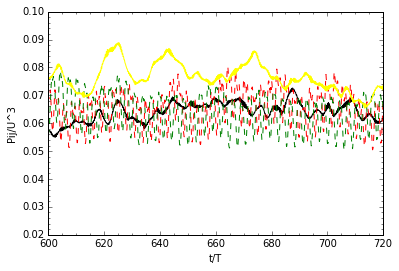

In [41]:
#show plot inline
%matplotlib inline
#plt.style.use('classic')
fig, ax = plt.subplots()
plt.plot(time, data[:,1],\
         time, data[:,2],\
         time, data[:,3],\
         time, data[:,4])
plt.gca().get_lines()[0].set_color("black")
plt.gca().get_lines()[1].set_color("red")
plt.gca().get_lines()[2].set_color("green")
plt.gca().get_lines()[3].set_color("yellow")
plt.gca().get_lines()[0].set_linestyle("-")
plt.gca().get_lines()[1].set_linestyle("--")
plt.gca().get_lines()[2].set_linestyle("--")
plt.gca().get_lines()[3].set_linestyle("-")
#plt.legend(['Fixed turbine','Pitch turbine','SWAY turbine', 'Fixed_no_swell'], \
#           loc='best', bbox_to_anchor=(0.35, 1.0))
plt.xlabel('t/T')
plt.ylabel('Pij/U^3')
#plt.title('power_density_average')
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.xlim([600,720])
plt.ylim([0.02,0.1])
plt.show()

In [31]:
#open nessesary file
path = 'd:\post\Project\Fixed_Turbine'
os.chdir(path)
fname = 'restart_hos.h5'
f = h5py.File(fname, "r")
eta = f["eta_hos"]
nx = eta.shape[0]
x = np.linspace(0, 2240, nx)

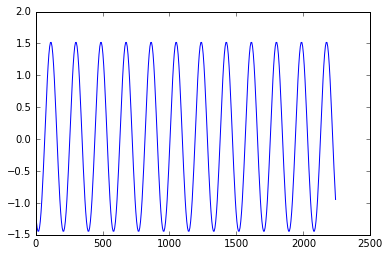

In [32]:
plt.plot(x, eta[0,:], label='eta_hos')
plt.show()

In [33]:
theta = np.arccos(eta[0,48]/np.max(eta[0,:]))
print(theta)

0.7069766345341104


In [34]:
omega = 4.9856115556811860E-002
amp = 0.04
print(len(time))
t = np.linspace(0, np.max(time), len(time))

45000
